In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [47]:
df = pd.read_csv('melb_split.csv')
print(df.shape)
df.head()

(13580, 22)


,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price,Split
0,Brighton,18 Rooding St,3,h,S,Buxton,3/09/2016,11.2,3186.0,3.0,...,366.0,156.0,1920.0,Bayside,-37.90380,145.00010,Southern Metropolitan,10579.0,1635000.0,Train
1,Coburg,11 Station St,3,h,S,Brad,23/04/2016,7.8,3058.0,3.0,...,238.0,131.0,1900.0,Moreland,-37.75390,144.96120,Northern Metropolitan,11204.0,725000.0,Train
2,Brunswick,106 Evans St,3,h,S,Ray,27/05/2017,5.2,3056.0,3.0,...,439.0,NaN,NaN,Moreland,-37.77047,144.97005,Northern Metropolitan,11918.0,1280000.0,Train
3,Carnegie,4/5 Anzac St,2,u,S,hockingstuart,4/06/2016,11.4,3163.0,2.0,...,0.0,100.0,1973.0,Glen Eira,-37.88630,145.06600,Southern Metropolitan,7822.0,772000.0,Train
4,Altona,64 Queen St,4,h,S,Greg,22/07/2017,11.0,3018.0,4.0,...,615.0,NaN,NaN,Hobsons Bay,-37.87057,144.83623,Western Metropolitan,5301.0,1360000.0,Train


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Method         13580 non-null  object 
 5   SellerG        13580 non-null  object 
 6   Date           13580 non-null  object 
 7   Distance       13580 non-null  float64
 8   Postcode       13580 non-null  float64
 9   Bedroom2       13580 non-null  float64
 10  Bathroom       13580 non-null  float64
 11  Car            13518 non-null  float64
 12  Landsize       13580 non-null  float64
 13  BuildingArea   7130 non-null   float64
 14  YearBuilt      8205 non-null   float64
 15  CouncilArea    12211 non-null  object 
 16  Lattitude      13580 non-null  float64
 17  Longtitude     13580 non-null  float64
 18  Region

In [49]:
df.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
Price               0
Split               0
dtype: int64

In [50]:
# 데이터셋 분리
train_data = df[df['Split'] == 'Train']
test_data = df[df['Split'] == 'Test']

# 타겟 변수와 특성 분리
y_train = train_data['Price']
X_train_full = train_data.drop(['Price', 'Split', 'Address', 'BuildingArea', 'YearBuilt'], axis=1)

y_test = test_data['Price']
X_test_full = test_data.drop(['Price', 'Split', 'Address', 'BuildingArea', 'YearBuilt'], axis=1)

In [51]:
# Cardinality를 기반으로 카테고리형 컬럼 선택
categorical_cols = [
    cname for cname in X_train_full.columns
    #if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == "object"
    if X_train_full[cname].dtype == "object"
]

# 숫자형 컬럼 선택
numerical_cols = [
    cname for cname in X_train_full.columns
    if X_train_full[cname].dtype in ['int64', 'float64']
]

# 선택된 컬럼만 유지
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# 결과 확인
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(X_train.columns)
print(X_test.columns)

X_train shape: (10864, 17)
y_train shape: (10864,)
X_test shape: (2716, 17)
y_test shape: (2716,)
Index(['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname', 'Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom',
       'Car', 'Landsize', 'Lattitude', 'Longtitude', 'Propertycount'],
      dtype='object')
Index(['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname', 'Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom',
       'Car', 'Landsize', 'Lattitude', 'Longtitude', 'Propertycount'],
      dtype='object')


In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Numerical 및 Categorical 데이터 전처리 정의
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 2. 전처리기 결합
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# 3. 모델 정의
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=0),
    "RandomForest": RandomForestRegressor(n_estimators=10, random_state=0),
    "XGBoost": XGBRegressor(n_estimators=10, random_state=0)
}

# 4. 파이프라인 생성 및 학습
for model_name, model in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),  # 스케일링 추가
        ('model', model)
    ])
    
    # 모델별 설정 변경 (RandomForest 예시)
    if model_name == "RandomForest":
        pipeline.steps[2][1].n_estimators = 100  # n_estimators 설정 변경
    
    # 모델 학습
    pipeline.fit(X_train, y_train)
    
    # 검증 데이터 예측 및 평가
    preds = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    
    # 결과 출력
    print(f"{model_name} Results:")
    print(f"  R² Score: {r2:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print("-" * 30)

Training LinearRegression...
LinearRegression Results:
  R² Score: 0.70
  MAE: 231791.36
  MSE: 119774128963.51
  RMSE: 346083.99
------------------------------
Training DecisionTree...
DecisionTree Results:
  R² Score: 0.58
  MAE: 229744.43
  MSE: 166431716646.31
  RMSE: 407960.44
------------------------------
Training RandomForest...
RandomForest Results:
  R² Score: 0.80
  MAE: 163284.33
  MSE: 81196616977.53
  RMSE: 284950.20
------------------------------
Training XGBoost...
XGBoost Results:
  R² Score: 0.78
  MAE: 184738.66
  MSE: 88989818026.93
  RMSE: 298311.61
------------------------------


In [53]:
print(my_cols)
print(X_train.columns)

['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname', 'Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Lattitude', 'Longtitude', 'Propertycount']
Index(['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname', 'Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom',
       'Car', 'Landsize', 'Lattitude', 'Longtitude', 'Propertycount'],
      dtype='object')


In [55]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Rooms', 'Distance',
                                                   'Postcode', 'Bedroom2',
                                                   'Bathroom', 'Car',
                                                   'Landsize', 'Lattitude',
                                                   'Longtitude',
                                                   'Propertycount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Suburb', 'Type', 'Method',
                                                   'SellerG', 'Date',
                                                   'CouncilArea',
                                                   'Regionname'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', DecisionTreeRegressor(random_state=0))])

Training LinearRegression...
Training DecisionTree...


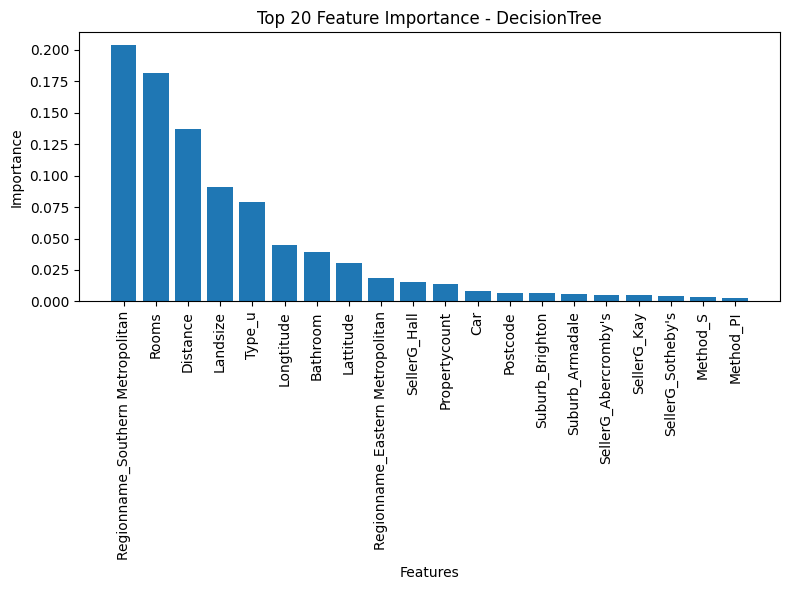

Training RandomForest...


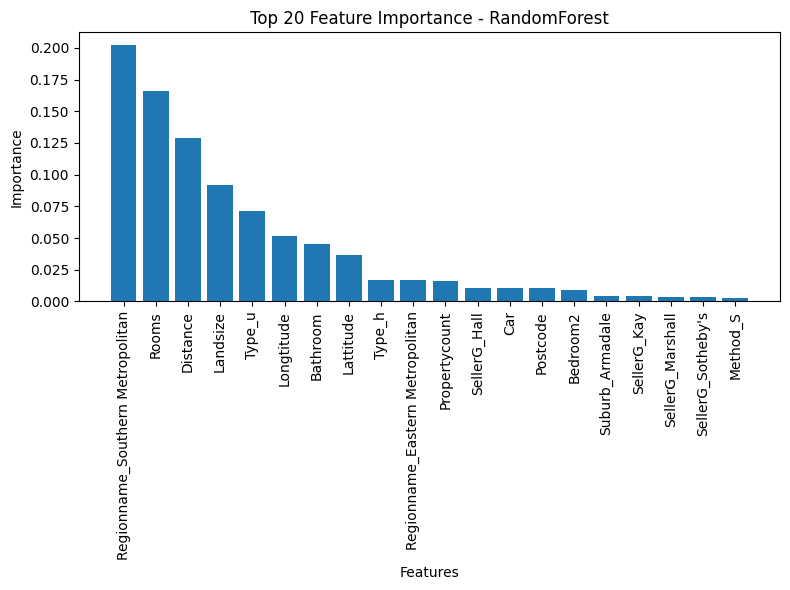

Training XGBoost...


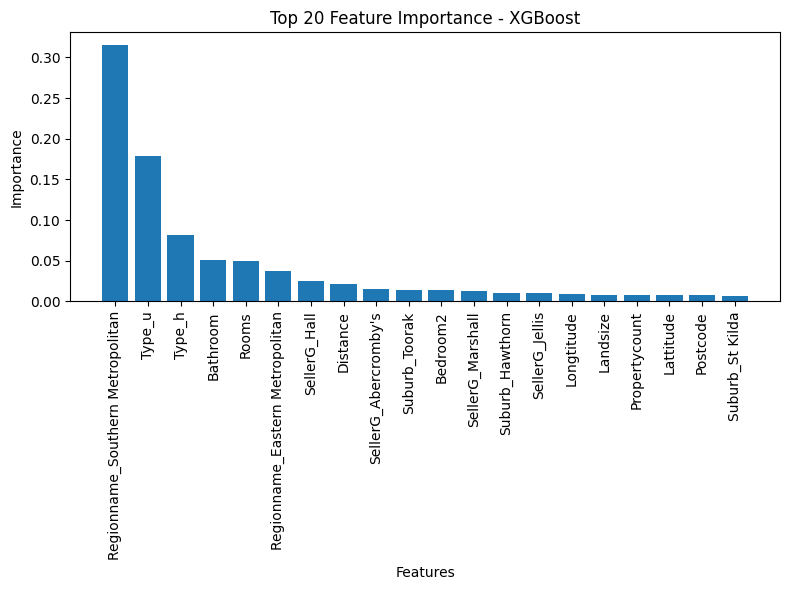

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression

# 1. Numerical 및 Categorical 데이터 전처리 정의
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 2. 전처리기 결합
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# ColumnTransformer 학습
preprocessor.fit(X_train)

# 전처리 후 열 이름 생성
numerical_feature_names = numerical_cols
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

# 3. 모델 정의
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=0),
    "RandomForest": RandomForestRegressor(n_estimators=10, random_state=0),
    "XGBoost": XGBRegressor(n_estimators=10, random_state=0)
}

def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]  # 중요도가 높은 순서로 정렬
        
        # 상위 20개 선택
        top_n = 20
        top_indices = indices[:top_n]

        plt.figure(figsize=(8, 6))
        plt.title(f"Top {top_n} Feature Importance - {model_name}")
        plt.bar(range(top_n), importances[top_indices], align="center")
        plt.xticks(range(top_n), np.array(feature_names)[top_indices], rotation=90)
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importances.")

# 4. 파이프라인 생성 및 학습
for model_name, model in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),  # 스케일링 추가
        ('model', model)
    ])
    
    # 모델 학습
    pipeline.fit(X_train, y_train)
    
    # Feature Importance 시각화
    if model_name in ["RandomForest", "DecisionTree", "XGBoost"]:
        trained_model = pipeline.named_steps['model']
        plot_feature_importance(trained_model, all_feature_names, model_name)
